In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.datasets import load_iris, load_wine

from scipy.spatial.distance import pdist

# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

import lib.baseline as baseline
import lib.util as util
from lib.baycon import baycon_explainer

from lib.eval.eval_metrics import *
from lib.dice_mod import Gainer, random_opt

%load_ext autoreload
%autoreload 2

In [ ]:
def plot_heatmap(X, y, C, random_point, fn, target_cluster, use_pca=False, solutions=None, histories=None):

    dim_ranges = np.abs(np.max(X, axis=0) - np.min(X, axis=0))
    samples = []
    for _ in range(1):
        sample = np.random.rand(1, X.shape[1]) * dim_ranges + np.min(X, axis=0)
        samples.append(sample)
    samples = np.array(samples).reshape(-1, X.shape[1])
    sample_gains = np.array([fn(point.reshape(1, -1)) for point in samples])
    best_samples = samples[np.argsort(-sample_gains)[:10]]
    bs = best_samples.copy()

    if use_pca:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
        C = pca.transform(C)
        best_samples = pca.transform(best_samples)
        random_point = pca.transform(random_point)
        if solution is not None:
            solution = pca.transform(solution)
        if history is not None:
            history = pca.transform(history)
    
    plt.figure(figsize=(10, 8))

    # Create a grid for the heatmap
    if not use_pca:
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                            np.linspace(y_min, y_max, 250))
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        values = np.array([fn(point.reshape(1, -1)) for point in grid_points])
        grid = values.reshape(xx.shape)
        plt.contourf(xx, yy, grid, levels=50, cmap='viridis', alpha=0.5)
        plt.colorbar(label='value')


    # values = np.array([fn(point.reshape(1, -1)) for point in samples])

    # Plot data points, cluster centers, and random point
    unique_labels = np.unique(y)
    palette = sns.color_palette("husl", len(unique_labels))  # Use a distinct color palette

    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette)
    sns.scatterplot(x=C[:, 0], y=C[:, 1], color='red', s=100, marker='o')
    sns.scatterplot(x=random_point[:, 0], y=random_point[:, 1], color='green', s=100, marker='o')
    # sns.scatterplot(x=best_samples[:, 0], y=best_samples[:, 1], color='blue', s=50, marker='x')
    if solutions is not None:
        for s in solutions:
            sns.scatterplot(x=s[:, 0], y=s[:, 1], color='purple', s=100, marker='o')
    if histories is not None:
        for h in histories:
            plt.plot(h[:, 0], h[:, 1], color='black', linewidth=1, linestyle='dashed', marker='o')

    plt.title(f'Heatmap of values for target cluster {target_cluster} ({fn.__name__})')
    # plt.axis('equal')
    plt.show()
    return bs

1.0000000000000002


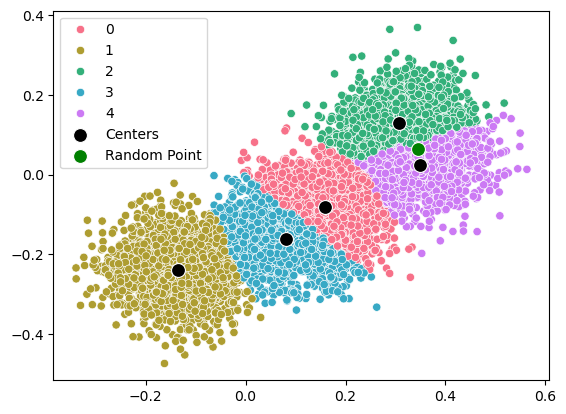

In [3]:
k = 5

X, _ = make_blobs(centers=k, cluster_std=2, n_features=2, n_samples=10000)
# X, y = load_iris(return_X_y=True)
# X = StandardScaler().fit_transform(X)
X = X / np.max(pdist(X))
print(np.max(pdist(X)))
# normalize to max 1 dist
km = KMeans(n_clusters=k)
y = km.fit_predict(X)
C = km.cluster_centers_

# random point from X:
random_point = X[[np.random.randint(0, X.shape[0])]]


def plot(X, y, C, x, pca=False):
    if pca:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
        C = pca.transform(C)
        x = pca.transform(x)
    unique_labels = np.unique(y)
    palette = sns.color_palette("husl", len(unique_labels))  # Use a distinct color palette
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette, legend="full")
    sns.scatterplot(x=C[:, 0], y=C[:, 1], color='black', s=100, marker='o', label='Centers')
    sns.scatterplot(x=x[:, 0], y=x[:, 1], color='green', s=100, marker='o', label='Random Point')
    plt.legend()
    plt.show()

plot(X, y, C, random_point, pca=False)

iter: 33
iter: 37
iter: 32
iter: 30
iter: 33


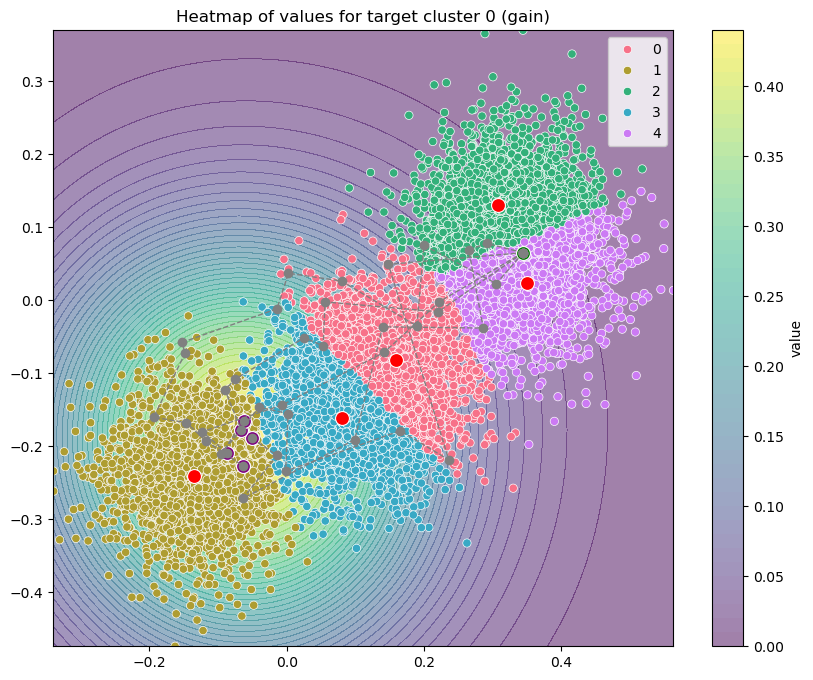

(1, 2)
iter: 25
iter: 25
iter: 25
iter: 25
iter: 25


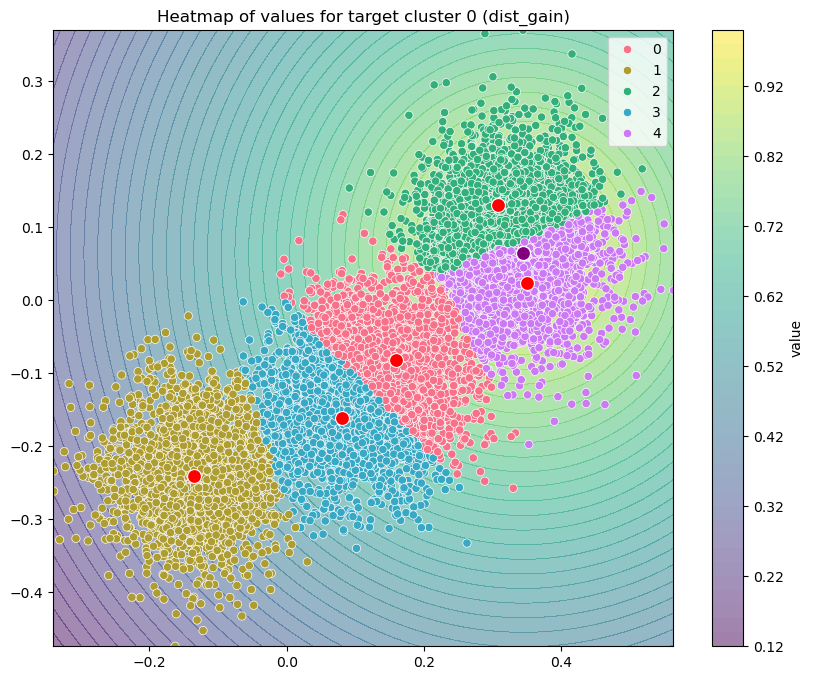

iter: 34
iter: 31
iter: 35
iter: 33
iter: 36


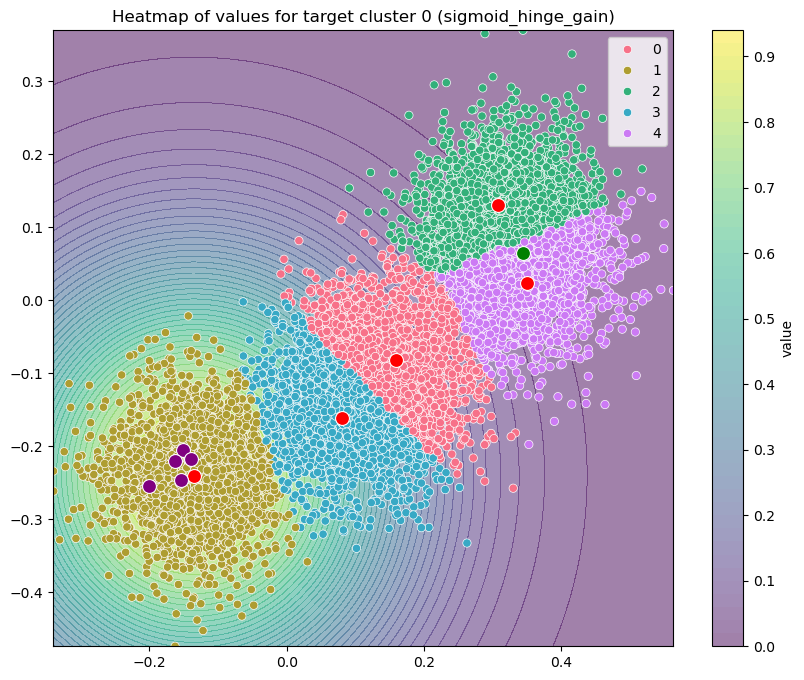

In [67]:
# Example usage
l = Gainer(C, X, 1, random_point)

sols = []
hists = []
for i in range(5):
    sol, hist = random_opt(random_point, l.gain)
    sols.append(sol)
    hists.append(hist)

best = plot_heatmap(
    X, y, C, random_point, l.gain, target_cluster=0, 
    use_pca=False, 
    solutions=sols, 
    histories=hists
)
print(best[0].reshape(1, -1).shape)

# valid = np.array([l.is_valid(point.reshape(1,-1)) for point in best])
# sparsity = np.array([l.sparsity_gain(point) for point in best])
# df = pd.DataFrame()
# df['valid'] = valid
# df['sparsity'] = sparsity
# print(df)

for lt in l.loss_weights.keys():
    sols = []
    hists = []
    for i in range(5):
        sol, hist = random_opt(random_point, lt)
        sols.append(sol)
        hists.append(hist)
    plot_heatmap(X, y, C, random_point, lt, target_cluster=0, use_pca=False, solutions=sols)

In [5]:
xx = np.linspace(0, 5, 1000)
yy = np.array([l.gain(x) for x in xx])
plt.plot(xx, yy)

IndexError: invalid index to scalar variable.